<a href="https://colab.research.google.com/github/7ylerpham/Hyperspectral_Image_Reduction/blob/main/dense_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

import tifffile

In [ ]:
''' Preprocessing '''
input_img = tifffile.imread('pau_stack.tiff')
input_img = input_img.astype(np.float64)
print(input_img.shape)

input_img = np.rollaxis(input_img, 2, 0)
print(input_img.shape)

new_img = np.zeros(input_img.shape)

# Band normalization
for i in range(len(input_img)):
    #used the normal way to normalize
    new_img[i] = (input_img[i] - np.min(input_img[i]))/(np.max(input_img[i])-np.min(input_img[i]))
print(new_img.shape)

before_norm = input_img.copy()
after_norm = new_img.copy()

# Reshape into (1D vector, bands)
new_img = np.rollaxis(new_img, 0, 3)
X = pd.DataFrame(new_img.reshape(new_img.shape[0]*new_img.shape[1], -1))
print(X.shape)

(145, 145, 200)
(200, 145, 145)
(200, 145, 145)
(21025, 200)


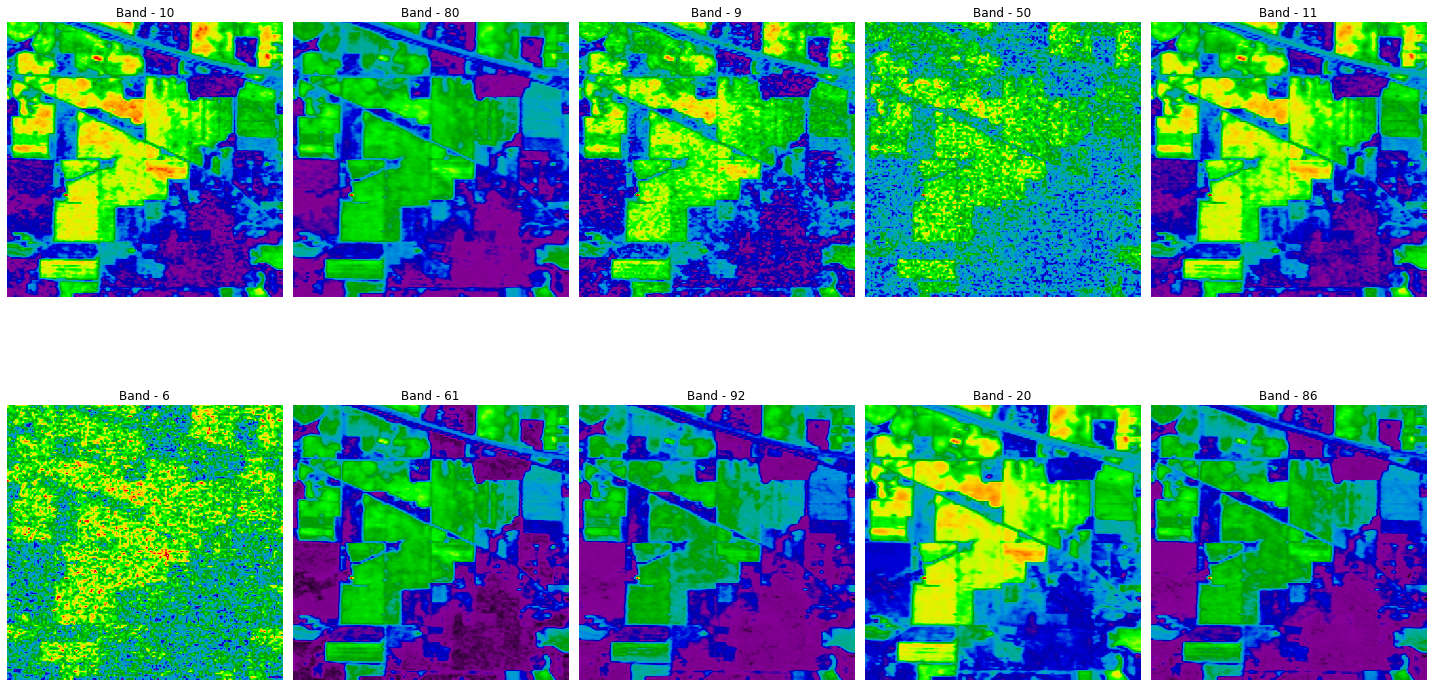

In [ ]:
''' Plotting for fun '''
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)
for i in range(2):
    for j in range(5):
        c = np.random.randint(103)
        ax[i][j].imshow(new_img[:, :, c], cmap="nipy_spectral")
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()
plt.show()

In [ ]:
''' AE Model '''
# Encoder dimension
encoding_dim = 5

input_dim = keras.Input(shape = (103, ), name = 'InputLayer')

# Encoder Layers
x = keras.layers.Dense(100, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(input_dim)
# x = keras.layers.Dense(100, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)
x = keras.layers.Dense(50, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)
x = keras.layers.Dense(25, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)

# Coded Part
encoded = keras.layers.Dense(encoding_dim, activation = 'linear', name = 'CodeLayer')(x)

# Decoder Layers
x = keras.layers.Dense(25, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(encoded)
x = keras.layers.Dense(50, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)
x = keras.layers.Dense(100, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)
# x = keras.layers.Dense(200, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)

output = keras.layers.Dense(103, activation = 'sigmoid')(x)

# Combine Encoder and Deocder layers
autoencoder = keras.Model(inputs = input_dim, outputs = output)

autoencoder.summary()

ValueError: ignored

In [ ]:
''' Compile & Fit The Model '''
autoencoder.compile(optimizer = 'adam', 
                    loss = 'mse', 
                    metrics = [tf.keras.metrics.MeanSquaredLogarithmicError()]
                    ) 

In [ ]:
# Fit the Model
hist = autoencoder.fit(X, X, epochs = 10, shuffle = True)

Epoch 1/10
6482/6482 [==============================] - 10s 2ms/step - loss: 0.0036 - mean_squared_logarithmic_error: 0.0023
Epoch 2/10
6482/6482 [==============================] - 10s 2ms/step - loss: 8.9097e-05 - mean_squared_logarithmic_error: 6.0875e-05
Epoch 3/10
6482/6482 [==============================] - 10s 2ms/step - loss: 6.0972e-05 - mean_squared_logarithmic_error: 4.1973e-05
Epoch 4/10
6482/6482 [==============================] - 10s 2ms/step - loss: 5.3244e-05 - mean_squared_logarithmic_error: 3.6044e-05
Epoch 5/10
6482/6482 [==============================] - 10s 2ms/step - loss: 4.5869e-05 - mean_squared_logarithmic_error: 3.1818e-05
Epoch 6/10
6482/6482 [==============================] - 10s 2ms/step - loss: 4.5098e-05 - mean_squared_logarithmic_error: 3.0960e-05
Epoch 7/10
6482/6482 [==============================] - 10s 2ms/step - loss: 5.1895e-05 - mean_squared_logarithmic_error: 3.5409e-05
Epoch 8/10
6482/6482 [==============================] - 10s 2ms/step - loss: 

In [ ]:
''' Encoder '''
encoder = keras.Model(inputs = input_dim, outputs = encoded)
encoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 103)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10400     
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 25)                1275      
_________________________________________________________________
CodeLayer (Dense)            (None, 5)                 130       
Total params: 16,855
Trainable params: 16,855
Non-trainable params: 0
_________________________________________________________________


In [ ]:
''' Get Encoded Reduced Dimesion '''
e_img = encoder.predict(X)

# Reshape vector back into image
e_img = np.rollaxis(e_img, 1, 0)
print(e_img.shape)
e_img = e_img.reshape(encoding_dim, 610, 340)
print(e_img.shape)

(5, 207400)
(5, 610, 340)


In [ ]:
''' Get AE Output '''
ae_img = autoencoder.predict(X)

# Reshape vector back into image
ae_img = np.rollaxis(ae_img, 1, 0)
print(ae_img.shape)
ae_img = ae_img.reshape(103, 610, 340)
print(ae_img.shape)

(103, 207400)
(103, 610, 340)


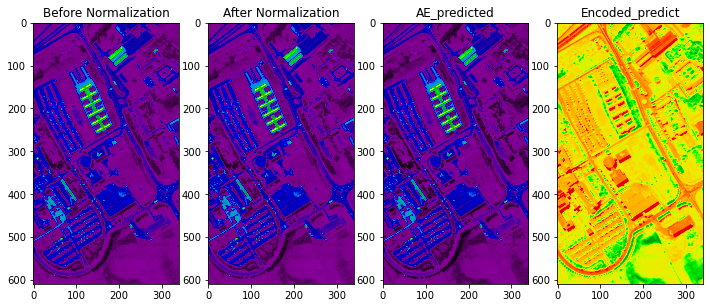

In [ ]:
fig = plt.figure(figsize = (12, 12))
plt.subplot(1, 4, 1)
plt.imshow(before_norm[2], cmap='nipy_spectral')
plt.title("Before Normalization")

plt.subplot(1, 4, 2)
plt.imshow(after_norm[2], cmap='nipy_spectral')
plt.title("After Normalization")

plt.subplot(1, 4, 3)
plt.imshow(ae_img[2], cmap='nipy_spectral')
plt.title("AE_predicted")

plt.subplot(1, 4, 4)
plt.imshow(e_img[0], cmap='nipy_spectral')
plt.title("Encoded_predict")
plt.show()

In [ ]:
'''
print("Visualizing the Encoded Bands")
fig = plt.figure(figsize = (15, 8))
plt.subplot(2, 5, 1)
plt.imshow(e_img[0], cmap='nipy_spectral')
plt.subplot(2, 5, 2)
plt.imshow(e_img[1], cmap='nipy_spectral')
plt.subplot(2, 5, 3)
plt.imshow(e_img[2], cmap='nipy_spectral')
plt.subplot(2, 5, 4)
plt.imshow(e_img[3], cmap='nipy_spectral')
plt.subplot(2, 5, 5)
plt.imshow(e_img[4], cmap='nipy_spectral')
plt.subplot(2, 5, 6)
plt.imshow(e_img[5], cmap='nipy_spectral')
plt.subplot(2, 5, 7)
plt.imshow(e_img[6], cmap='nipy_spectral')
plt.subplot(2, 5, 8)
plt.imshow(e_img[7], cmap='nipy_spectral')
plt.subplot(2, 5, 9)
plt.imshow(e_img[8], cmap='nipy_spectral')
plt.subplot(2, 5, 10)
plt.imshow(e_img[9], cmap='nipy_spectral')
plt.show()
'''

'\nprint("Visualizing the Encoded Bands")\nfig = plt.figure(figsize = (15, 8))\nplt.subplot(2, 5, 1)\nplt.imshow(e_img[0], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 2)\nplt.imshow(e_img[1], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 3)\nplt.imshow(e_img[2], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 4)\nplt.imshow(e_img[3], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 5)\nplt.imshow(e_img[4], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 6)\nplt.imshow(e_img[5], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 7)\nplt.imshow(e_img[6], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 8)\nplt.imshow(e_img[7], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 9)\nplt.imshow(e_img[8], cmap=\'nipy_spectral\')\nplt.subplot(2, 5, 10)\nplt.imshow(e_img[9], cmap=\'nipy_spectral\')\nplt.show()\n'

In [ ]:
''' Saving Each Band '''
print(e_img.shape)
for count, band in enumerate(e_img):
        band = band.reshape(1, 610, 340)
        band = np.rollaxis(band, 0, 3)
        tifffile.imsave("pau_ae_"+str(encoding_dim)+"_band_" + str(count) + ".tiff", band)
        print(band.shape)

(5, 610, 340)
(610, 340, 1)
(610, 340, 1)
(610, 340, 1)
(610, 340, 1)
(610, 340, 1)


In [ ]:
'''Saving Models'''
autoencoder.save("pau_dense_ae_" + str(encoding_dim) + ".h5")
encoder.save("pau_dense_encoder_" + str(encoding_dim) + ".h5")